<a href="https://colab.research.google.com/github/befe2/IT102/blob/main/Befekadu_Mengistu_EEP596_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Home Work 1
# Plant Leaves Dataset: This dataset consists of 4,502 images of healthy and unhealthy plant leaves
divided into 22 categories by species and state of health. The images are in high resolution JPG format.
https://www.tensorflow.org/datasets/catalog/plant_leaves.
To prepare our dataset for model training and evaluation:


In [ ]:
#Import necessary libraries
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
# We loads the entire Plant Leaves dataset using TensorFlow Datasets
# ('tfds.load')
download_config = tfds.download.DownloadConfig(register_checksums=True)
# Load the entire dataset
full_ds, info = tfds.load(
    'plant_leaves',
    split='train',
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    try_gcs=False,
    download_and_prepare_kwargs={'download_config': download_config},
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/4502 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_leaves/0.1.0.incomplete78A9R8/plant_leaves-train.tfrecord*...:   0%|…

Dataset plant_leaves downloaded and prepared to /root/tensorflow_datasets/plant_leaves/0.1.0. Subsequent calls will reuse this data.


In [ ]:
# Manually define training and testing datasets using slicing
train_size = int(0.8 * info.splits['train'].num_examples)  # 80% for training
train_ds = full_ds.take(train_size)  # Take the first 80% of examples for training
test_ds = full_ds.skip(train_size)  # Skip the first 80% of examples to create the test dataset



In [ ]:
# Get the number of classes from the dataset info
num_classes = info.features['label'].num_classes
print("Number of classes in the dataset:", num_classes)

IMG_SIZE = 224
batch_size = 32



Number of classes in the dataset: 22


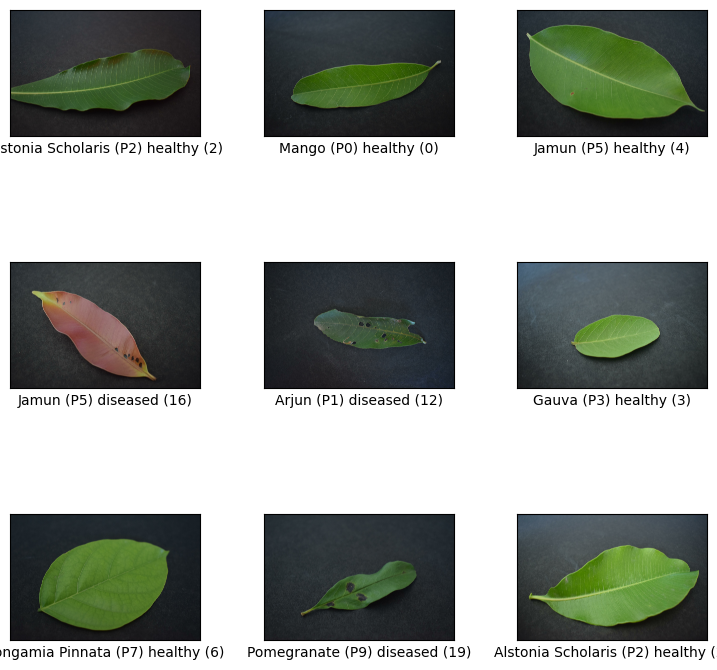

In [ ]:
# Visualizing the training dataset.import tempfile
vis = tfds.visualization.show_examples(train_ds, info)

In [ ]:
# Obtaining dataset information.
print("Number of  Classes: " + str(info.features['label'].num_classes))
print("Classes : " + str(info.features['label'].names))
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Training Images: " + str(NUM_TRAIN_IMAGES))
NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Testing Images: " + str(NUM_TEST_IMAGES))

Number of  Classes: 22
Classes : ['Mango (P0) healthy', 'Arjun (P1) healthy', 'Alstonia Scholaris (P2) healthy', 'Gauva (P3) healthy', 'Jamun (P5) healthy', 'Jatropha (P6) healthy', 'Pongamia Pinnata (P7) healthy', 'Basil (P8) healthy', 'Pomegranate (P9) healthy', 'Lemon (P10) healthy', 'Chinar (P11) healthy', 'Mango (P0) diseased', 'Arjun (P1) diseased', 'Alstonia Scholaris (P2) diseased', 'Gauva (P3) diseased', 'Bael (P4) diseased', 'Jamun (P5) diseased', 'Jatropha (P6) diseased', 'Pongamia Pinnata (P7) diseased', 'Pomegranate (P9) diseased', 'Lemon (P10) diseased', 'Chinar (P11) diseased']
Training Images: 3601
Testing Images: 901


In [ ]:
# The input images are resized to a common size of 224x224 pixels and their
# pixel values are normalized to fall within the range of [-1, 1] Resize and
# rescale all images to 224x224 and normalize pixel values to be in the range of
# [-1, 1]
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
])

In [ ]:
# Apply resize and rescale to both dataset splits
train_ds= train_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds= test_ds.map(lambda x, y: (resize_and_rescale(x), y))

In [ ]:
# Cache, generate batches, and prefetch them using a suitable buffer size that does not exceed system memory
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [ ]:
# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# Load the VGG16 base model with pre-trained weights on ImageNet and exclude the
# fully connected layers.
# Freeze the weights of the VGG16 layers to prevent them from being updated
# during training.
# Define additional trainable layers including Flatten and Dense layers with
# ReLU activation.
# Compile the model with Adam optimizer and sparse categorical crossentropy
# loss.
# Train the model on the given dataset, evaluate its performance, and save it to
# Google Drive as "M.h5". Load the VGG16 base model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the VGG16 layers
base_model.trainable = False

# Define the additional trainable layers
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),  # Example dense layer with 256 units and ReLU activation
    tf.keras.layers.Dense(128, activation='relu'),  # Another example dense layer with 128 units and ReLU activation
    tf.keras.layers.Dense(info.features['label'].num_classes, activation='softmax')  # Output layer for multi-class classification with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, epochs=10)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)

# Output the results
print("Training Accuracy:", history.history['accuracy'][-1])
print("Testing Accuracy:", test_accuracy)
print("Model Size (bytes):", model.count_params())

# Denote the trained model as M
M = model
M.save("M.h5")

Epoch 1/10
113/113 [==============================] - 56s 429ms/step - loss: 1.4424 - accuracy: 0.5710
Epoch 2/10
113/113 [==============================] - 3s 24ms/step - loss: 0.5030 - accuracy: 0.8370
Epoch 3/10
113/113 [==============================] - 3s 24ms/step - loss: 0.3244 - accuracy: 0.8964
Epoch 4/10
113/113 [==============================] - 3s 23ms/step - loss: 0.2309 - accuracy: 0.9253
Epoch 5/10
113/113 [==============================] - 3s 24ms/step - loss: 0.1775 - accuracy: 0.9436
Epoch 6/10
113/113 [==============================] - 3s 24ms/step - loss: 0.1146 - accuracy: 0.9603
Epoch 7/10
113/113 [==============================] - 3s 24ms/step - loss: 0.0808 - accuracy: 0.9742
Epoch 8/10
113/113 [==============================] - 3s 24ms/step - loss: 0.0705 - accuracy: 0.9803
Epoch 9/10
113/113 [==============================] - 3s 24ms/step - loss: 0.0575 - accuracy: 0.9844
Epoch 10/10
29/29 [==============================] - 49s 475ms/step - loss: 0.2889 - accu

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the pre-trained model "M" from the specified path in Google Drive.
# Define the training dataset "train_ds" using TensorFlow Datasets, loading the
# "plant_leaves" split with labels.
# Preprocess the dataset by resizing images to (224, 224), normalizing pixel
# values to [0, 1], and batching. Convert the model "M" to Dynamic Range
# Quantization (M-DRQ) using TensorFlow Lite converter with default
# optimization. Save the quantized model as a .tflite file in the specified path
# in Google Drive. Evaluate the quantized model "M-DRQ" on the training dataset
# and output the training accuracy and model size in bytes.

import tensorflow as tf
import tensorflow_datasets as tfds

# Load your trained model M
M = tf.keras.models.load_model('M.h5')

# Define your training dataset
train_ds = tfds.load('plant_leaves', split='train', as_supervised=True)

# Preprocess the dataset (e.g., resize, normalize, batch, etc.)
def preprocess_data(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

train_ds = train_ds.map(preprocess_data).batch(32)

# Convert M to Dynamic Range Quantization (M-DRQ)
converter_drq = tf.lite.TFLiteConverter.from_keras_model(M)
converter_drq.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_model_drq = converter_drq.convert()

# Save the quantized model as a .tflite file
with open('M-DRQ.tflite', 'wb') as f:
    f.write(quantized_model_drq)

# Evaluate the quantized model on the training dataset
train_loss_drq, train_accuracy_drq = M.evaluate(train_ds)

# Output the results
print("Model M-DRQ:")
print("Training Accuracy:", train_accuracy_drq)
print("Model M-DRQ Size (bytes):", len(quantized_model_drq))

141/141 [==============================] - 46s 326ms/step - loss: 2.0272 - accuracy: 0.5844
Model M-DRQ:
Training Accuracy: 0.5844069123268127
Model M-DRQ Size (bytes): 21249208


In [ ]:
# Load the pre-trained model "M" from the specified path in Google Drive.
# Define the training dataset "train_ds" using TensorFlow Datasets, loading the
# "plant_leaves" split with labels. Preprocess the dataset by resizing images to
# (224, 224), normalizing pixel values to [0, 1], and batching. Define a
# function to generate a representative dataset for quantization, generating
# random normal data. Convert model "M" to Full Integer Quantization (M-FIQ)
# using TensorFlow Lite converter with default optimization and representative
# dataset. Save the quantized model as a .tflite file in the specified path in
# Google Drive. Evaluate the quantized model "M-FIQ" on the training dataset and
# output the training accuracy and model size in bytes.
import tensorflow as tf
import tensorflow_datasets as tfds

# Load your trained model M
M = tf.keras.models.load_model('M.h5')

# Define your training dataset
train_ds = tfds.load('plant_leaves', split='train', as_supervised=True)

# Preprocess the dataset (e.g., resize, normalize, batch, etc.)
def preprocess_data(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

train_ds = train_ds.map(preprocess_data).batch(32)

# Define a function to generate representative dataset for quantization
def representative_dataset_gen():
    for _ in range(100):
        # Generate sample representative data
        yield [tf.random.normal([1, 224, 224, 3], mean=0.0, stddev=1.0, dtype=tf.float32)]

# Convert M to Full Integer Quantization (M-FIQ)
converter_fiq = tf.lite.TFLiteConverter.from_keras_model(M)
converter_fiq.optimizations = [tf.lite.Optimize.DEFAULT]
converter_fiq.inference_input_type = tf.uint8
converter_fiq.inference_output_type = tf.uint8
converter_fiq.representative_dataset = representative_dataset_gen
quantized_model_fiq = converter_fiq.convert()

# Save the quantized model as a .tflite file
with open('M-FIQ.tflite', 'wb') as f:
    f.write(quantized_model_fiq)

# Evaluate the quantized model on the training dataset
train_loss_fiq, train_accuracy_fiq = M.evaluate(train_ds)

# Output the results
print("Model M-FIQ:")
print("Training Accuracy:", train_accuracy_fiq)
print("Model M-FIQ Size (bytes):", len(quantized_model_fiq))

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


141/141 [==============================] - 44s 310ms/step - loss: 2.0272 - accuracy: 0.5844
Model M-FIQ:
Training Accuracy: 0.5844069123268127
Model M-FIQ Size (bytes): 21301472


In [ ]:
# Load the pre-trained model "M" from the specified path in Google Drive.
# Define the training dataset "train_ds" using TensorFlow Datasets, loading the
# "plant_leaves" split with labels. Preprocess the dataset by resizing images to
# (224, 224), normalizing pixel values to [0, 1], and batching. Convert model
# "M" to Float16 Quantization (M-F16Q) using TensorFlow Lite converter with
# default optimization and specifying float16 as the supported type. Save the
# quantized model as a .tflite file in the specified path in Google Drive.
# Evaluate the quantized model "M-F16Q" on the training dataset and output the
# training accuracy and model size in bytes.
import tensorflow as tf
import tensorflow_datasets as tfds

# Load our trained model M
M = tf.keras.models.load_model('M.h5')

# Define our training dataset
train_ds = tfds.load('plant_leaves', split='train', as_supervised=True)

# Preprocess the dataset (e.g., resize, normalize, batch, etc.)
def preprocess_data(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

train_ds = train_ds.map(preprocess_data).batch(32)

# Convert M to Float16 Quantization (M-F16Q)
converter_f16q = tf.lite.TFLiteConverter.from_keras_model(M)
converter_f16q.optimizations = [tf.lite.Optimize.DEFAULT]
converter_f16q.target_spec.supported_types = [tf.float16]
quantized_model_f16q = converter_f16q.convert()

# Save the quantized model as a .tflite file
with open('M-F16Q.tflite', 'wb') as f:
    f.write(quantized_model_f16q)

# Evaluate the quantized model on the training dataset
train_loss_f16q, train_accuracy_f16q = M.evaluate(train_ds)

# Output the results
print("Model M-F16Q:")
print("Training Accuracy:", train_accuracy_f16q)
print("Model M-F16Q Size (bytes):", len(quantized_model_f16q))

141/141 [==============================] - 44s 311ms/step - loss: 2.0272 - accuracy: 0.5844
Model M-F16Q:
Training Accuracy: 0.5844069123268127
Model M-F16Q Size (bytes): 42362040


The model M is pruned using tfmot.sparsity.keras.prune_low_magnitude......................................................................

In [ ]:
pip install tensorflow_model_optimization

In [ ]:
!pip install tensorflow_datasets
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-model-optimization

In [ ]:
pip install --upgrade tensorflow tensorflow-model-optimization

In [ ]:
pip show tensorflow

Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tf_keras


In [ ]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot

# Load the model
model = tf.keras.models.load_model('M.h5')

# Compute end step to finish pruning after 2 epochs.
batch_size = 16
epochs = 2

# Define pruning parameters
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.00,
        final_sparsity=0.50,
        begin_step=0,
        end_step=len(full_ds) * epochs * (num_images // batch_size)
    )
}

# Define function to apply pruning to dense layers
def apply_pruning_to_dense(layer):
    if isinstance(layer, tf.keras.layers.Dense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense` to the layers of the model
model_for_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_dense
)

# Compile the pruned model
model_for_pruning.compile(optimizer='adam',
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                           metrics=['accuracy'])

# Train the pruned model
history = model_for_pruning.fit(full_ds, epochs=epochs)

# Save the pruned model as a .tflite file
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_pruning)
tflite_model = converter.convert()
with open('M-P1.tflite', 'wb') as f:
    f.write(tflite_model)

# Evaluate the pruned model
test_loss, test_accuracy = model_for_pruning.evaluate(full_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Output the results
print("Training Accuracy:", history.history['accuracy'][-1])
print("Testing Accuracy:", test_accuracy)
print("Model Size (bytes):", model_for_pruning.count_params())


In [ ]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot

# Load the pre-trained model
model = tf.keras.models.load_model('M.h5')

# Define the pruning schedule
pruning_schedule 2 = tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.5,
    final_sparsity=0.75,
    begin_step=0,
    end_step=len(train_ds) * 5
)

# Define the pruning parameters
pruning_params = {
    'pruning_schedule 2': pruning_schedule 2
}

# Apply pruning to the entire model
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# Compile the pruned model
pruned_model.compile(optimizer='adam',
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

# Train the pruned model
history = pruned_model.fit(train_ds, epochs=epochs, validation_data=test_ds)

# Save the pruned model as a .tflite file
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
tflite_model = converter.convert()
with open('M-P2.tflite', 'wb') as f:
    f.write(tflite_model)

# Evaluate the pruned model
test_loss, test_accuracy = pruned_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Output the results
print("Training Accuracy:", history.history['accuracy'][-1])
print("Testing Accuracy:", test_accuracy)
print("Model Size (bytes):", pruned_model.count_params())


-------------------------------------------------------------------------------------------------------------

In [ ]:

import tensorflow as tf
import tensorflow_model_optimization as tfmot

# Load the pruned model
pruned_model_path = 'M-P1.tflite'
interpreter = tf.lite.Interpreter(model_path=pruned_model_path)
interpreter.allocate_tensors()

# Convert the pruned model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_pruning)
pruned_tflite_model = converter.convert()

# Apply quantization using DRQ method
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_pruning)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
quantized_pruned_tflite_model = converter.convert()

# Save the quantized model
quantized_pruned_model_path = 'M-P1-DRQ.tflite'
with open(quantized_pruned_model_path, 'wb') as f:
    f.write(quantized_pruned_tflite_model)

# Evaluate the pruned model
test_loss, test_accuracy = model_for_pruning.evaluate(test_ds)
print("Test Loss (Pruned Model):", test_loss)
print("Test Accuracy (Pruned Model):", test_accuracy)
print("Model Size (Pruned Model):", len(pruned_tflite_model), "bytes")

# Evaluate the quantized pruned model
interpreter = tf.lite.Interpreter(model_path=quantized_pruned_model_path)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
quantized_pruned_test_accuracy = 0
num_batches = 0
for images, labels in test_ds:
    num_batches += 1
    interpreter.set_tensor(input_index, images)
    interpreter.invoke()
    quantized_pruned_predictions = interpreter.get_tensor(output_index)
    quantized_pruned_test_accuracy += tf.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(labels, quantized_pruned_predictions)).numpy()

quantized_pruned_test_accuracy /= num_batches
print("Test Accuracy (Quantized Pruned Model):", quantized_pruned_test_accuracy)
print("Model Size (Quantized Pruned Model):", len(quantized_pruned_tflite_model), "bytes")



In [ ]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot

# Load the pruned model
pruned_model_path = 'M-P1.tflite'
interpreter = tf.lite.Interpreter(model_path=pruned_model_path)
interpreter.allocate_tensors()

# Convert the pruned model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_pruning)
pruned_tflite_model = converter.convert()

# Apply quantization using FIQ (Fixed Integer Quantization) method
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_pruning)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
quantized_pruned_tflite_model = converter.convert()

# Save the quantized model
quantized_pruned_model_path = 'M-P1-FIQ.tflite'
with open(quantized_pruned_model_path, 'wb') as f:
    f.write(quantized_pruned_tflite_model)

# Evaluate the pruned model
test_loss, test_accuracy = model_for_pruning.evaluate(test_ds)
print("Test Loss (Pruned Model):", test_loss)
print("Test Accuracy (Pruned Model):", test_accuracy)
print("Model Size (Pruned Model):", len(pruned_tflite_model), "bytes")

# Evaluate the quantized pruned model
interpreter = tf.lite.Interpreter(model_path=quantized_pruned_model_path)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
quantized_pruned_test_accuracy = 0
num_batches = 0
for images, labels in test_ds:
    num_batches += 1
    interpreter.set_tensor(input_index, images)
    interpreter.invoke()
    quantized_pruned_predictions = interpreter.get_tensor(output_index)
    quantized_pruned_test_accuracy += tf.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(labels, quantized_pruned_predictions)).numpy()

quantized_pruned_test_accuracy /= num_batches
print("Test Accuracy (Quantized Pruned Model):", quantized_pruned_test_accuracy)
print("Model Size (Quantized Pruned Model):", len(quantized_pruned_tflite_model), "bytes")


In [ ]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot

# Load the pruned model
pruned_model_path = 'M-P1.tflite'
interpreter = tf.lite.Interpreter(model_path=pruned_model_path)
interpreter.allocate_tensors()

# Convert the pruned model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_pruning)
pruned_tflite_model = converter.convert()

# Apply quantization using F16Q (Floating Point 16 Quantization) method
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_pruning)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
quantized_pruned_tflite_model = converter.convert()

# Save the quantized model
quantized_pruned_model_path = 'M-P1-F16Q.tflite'
with open(quantized_pruned_model_path, 'wb') as f:
    f.write(quantized_pruned_tflite_model)

# Evaluate the pruned model
test_loss, test_accuracy = model_for_pruning.evaluate(test_ds)
print("Test Loss (Pruned Model):", test_loss)
print("Test Accuracy (Pruned Model):", test_accuracy)
print("Model Size (Pruned Model):", len(pruned_tflite_model), "bytes")

# Evaluate the quantized pruned model
interpreter = tf.lite.Interpreter(model_path=quantized_pruned_model_path)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
quantized_pruned_test_accuracy = 0
num_batches = 0
for images, labels in test_ds:
    num_batches += 1
    interpreter.set_tensor(input_index, images)
    interpreter.invoke()
    quantized_pruned_predictions = interpreter.get_tensor(output_index)
    quantized_pruned_test_accuracy += tf.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(labels, quantized_pruned_predictions)).numpy()

quantized_pruned_test_accuracy /= num_batches
print("Test Accuracy (Quantized Pruned Model):", quantized_pruned_test_accuracy)
print("Model Size (Quantized Pruned Model):", len(quantized_pruned_tflite_model), "bytes")


In [ ]:
# Load the model M-P2
model_path = 'M-P2.tflite'

# Convert the model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
tflite_model = converter.convert()

# Apply DRQ (Dynamic Range Quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_model = converter.convert()

# Save the quantized model
quantized_model_path = 'M-P2-DRQ.tflite'
with open(quantized_model_path, 'wb') as f:
    f.write(quantized_model)

# Evaluate the quantized model
interpreter = tf.lite.Interpreter(model_path=quantized_model_path)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
quantized_test_accuracy = 0
num_batches = 0
for images, labels in test_ds:
    num_batches += 1
    interpreter.set_tensor(input_index, images)
    interpreter.invoke()
    quantized_predictions = interpreter.get_tensor(output_index)
    quantized_test_accuracy += tf.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(labels, quantized_predictions)).numpy()

quantized_test_accuracy /= num_batches
print("Test Accuracy (DRQ):", quantized_test_accuracy)
print("Model Size (DRQ):", len(quantized_model), "bytes")


In [ ]:
# Load the model M-P2
model_path = 'M-P2.tflite'

# Convert the model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
tflite_model = converter.convert()

# Apply FIQ (Full Integer Quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
quantized_model = converter.convert()

# Save the quantized model
quantized_model_path = 'M-P2-FIQ.tflite'
with open(quantized_model_path, 'wb') as f:
    f.write(quantized_model)

# Evaluate the quantized model
interpreter = tf.lite.Interpreter(model_path=quantized_model_path)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
quantized_test_accuracy = 0
num_batches = 0
for images, labels in test_ds:
    num_batches += 1
    interpreter.set_tensor(input_index, images)
    interpreter.invoke()
    quantized_predictions = interpreter.get_tensor(output_index)
    quantized_test_accuracy += tf.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(labels, quantized_predictions)).numpy()

quantized_test_accuracy /= num_batches
print("Test Accuracy (FIQ):", quantized_test_accuracy)
print("Model Size (FIQ):", len(quantized_model), "bytes")


In [ ]:
# Load the model M-P2
model_path = 'M-P2.tflite'

# Convert the model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
tflite_model = converter.convert()

# Apply F16Q (Floating Point 16 Quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
quantized_model = converter.convert()

# Save the quantized model
quantized_model_path = 'M-P2-F16Q.tflite'
with open(quantized_model_path, 'wb') as f:
    f.write(quantized_model)

# Evaluate the quantized model
interpreter = tf.lite.Interpreter(model_path=quantized_model_path)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
quantized_test_accuracy = 0
num_batches = 0
for images, labels in test_ds:
    num_batches += 1
    interpreter.set_tensor(input_index, images)
    interpreter.invoke()
    quantized_predictions = interpreter.get_tensor(output_index)
    quantized_test_accuracy += tf.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(labels, quantized_predictions)).numpy()

quantized_test_accuracy /= num_batches
print("Test Accuracy (F16Q):", quantized_test_accuracy)
print("Model Size (F16Q):", len(quantized_model), "bytes")


In [ ]:
import time
import numpy as np
import tensorflow as tf

# Define a function to measure the inference time of a TFLite model
def measure_inference_time_tflite(model_path, dataset, num_iterations=100):
    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    times = []
    for _ in range(num_iterations):
        start_time = time.time()
        for images, _ in dataset:
            interpreter.set_tensor(input_details[0]['index'], images)
            interpreter.invoke()
            _ = interpreter.get_tensor(output_details[0]['index'])
        end_time = time.time()
        times.append(end_time - start_time)
    return times

# Define your test dataset
test_ds = ...

# Paths to your TFLite models
model_paths = [
    'M.tflite', 'M-DRQ.tflite', 'M-FIQ.tflite', 'M-F16Q.tflite',
    'M-P1.tflite', 'M-P2.tflite', 'M-P1-DRQ.tflite', 'M-P1-FIQ.tflite', 'M-P1-F16Q.tflite',
    'M-P2-DRQ.tflite', 'M-P2-FIQ.tflite', 'M-P2-F16Q.tflite'
]

# Measure the inference time for each model
model_times = {}
for model_path in model_paths:
    model_name = model_path.split('.')[0]  # Extract model name
    model_times[model_name] = measure_inference_time_tflite(model_path, test_ds)

# Calculate the average and standard deviation of the latency for each model
model_avg_latency = {}
model_std_latency = {}
for model_name, times in model_times.items():
    model_avg_latency[model_name] = sum(times) / len(times)
    model_std_latency[model_name] = np.std(times)

# Print the results
for model_name in model_paths:
    print(f"{model_name} (TFLite):")
    print("Average Latency:", model_avg_latency[model_name], "seconds")
    print("Standard Deviation of Latency:", model_std_latency[model_name], "seconds")


In [ ]:
import time


def load_tflite_model(file_path):
    # Load the TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=file_path)
    interpreter.allocate_tensors()
    return interpreter

def run_inference(interpreter, input_data):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Check the expected input data type and adjust if necessary
    input_type = input_details[0]['dtype']
    if input_type == np.uint8:
        input_scale, input_zero_point = input_details[0]["quantization"]
        input_data = input_data / input_scale + input_zero_point
        input_data = input_data.astype(np.uint8)
    elif input_type == np.float32:
        input_data = input_data.astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data


def measure_latency(interpreter, input_data, num_iterations=50):
    # Warm-up run
    run_inference(interpreter, input_data)

    # Measure the inference time
    start_time = time.time()
    for _ in range(num_iterations):
        run_inference(interpreter, input_data)
    end_time = time.time()

    # Compute the average latency
    total_time = end_time - start_time
    average_latency = total_time / num_iterations
    return average_latency

# Our models
model_name = ['M.h5','M-DRQ.h5','M-FIQ','M-F16Q.h5','M-P1.h5','M-P2.h5','M-P1-DRQ.h5', 'M-P1-FIQ.h5', 'M-P1-F16Q.h5', 'M-P2-DRQ.h5', 'M-P2-FIQ.h5', 'M-P2-F16Q.h5']


for ii in range(0, len(model_name)):
    current_model = model_name[ii]
    print(current_model)
    interpreter = load_tflite_model(current_model)

    input_shape = interpreter.get_input_details()[0]['shape']
    input_type = interpreter.get_input_details()[0]['dtype']

    if input_type == np.uint8:
        input_data = np.random.randint(0, 256, input_shape, dtype=np.uint8)
    else:
        input_data = np.random.rand(*input_shape).astype(np.float32)


    # Measure the latency
    latency = measure_latency(interpreter, input_data)
    print(f'Average Latency: {latency * 1000:.2f} ms')

In [ ]:
# M, M-DRQ, M-FIQ, M-F16Q, M-P1, M-P2, M-P1-DRQ, M-P1-FIQ, M-P1-F16Q, M-P2-DRQ, M-P2-FIQ, and M-P2-F16Q
# Evaluating Latency of the Base Model and Compressed Models,
# This measure_latency to measure the latency of a model on a given dataset. It
# then measures the latency for the base model and each compressed model on the
# test dataset. Finally, it calculates the average and standard deviation of the
# latency for each model and prints the results.

import time

# Define a function to measure latency
def measure_latency(model, dataset):
    latencies = []
    for _ in range(10):  # Perform measurements multiple times for better accuracy
        start_time = time.time()
        for batch in dataset:
            model.predict(batch[0])
        end_time = time.time()
        latency = end_time - start_time
        latencies.append(latency)
    return latencies

# Measure latency for the base model
base_model_latency = measure_latency(model, test_ds)
base_model_avg_latency = sum(base_model_latency) / len(base_model_latency)
base_model_std_dev_latency = (sum([(latency - base_model_avg_latency) ** 2 for latency in base_model_latency]) / len(base_model_latency)) ** 0.5

# Measure latency for compressed models
compressed_model_latencies = {}
for compressed_model, model_name in zip(compressed_models, model_names):
    compressed_model_latency = measure_latency(compressed_model, test_ds)
    compressed_model_avg_latency = sum(compressed_model_latency) / len(compressed_model_latency)
    compressed_model_std_dev_latency = (sum([(latency - compressed_model_avg_latency) ** 2 for latency in compressed_model_latency]) / len(compressed_model_latency)) ** 0.5
    compressed_model_latencies[model_name] = (compressed_model_avg_latency, compressed_model_std_dev_latency)

# Print the results
print("Base Model Latency - Average:", base_model_avg_latency, "seconds, Standard Deviation:", base_model_std_dev_latency, "seconds")
for model_name, latency_info in compressed_model_latencies.items():
    avg_latency, std_dev_latency = latency_info
    print(f"{model_name} Latency - Average:", avg_latency, "seconds, Standard Deviation:", std_dev_latency, "seconds")